# Outline

This notebook is for comparing the dynamical and stochastic models from scVelo

In [29]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib
import igraph
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import scanpy as sc
import os
import re
from matplotlib_venn import venn2

In [43]:
def velo_len_conf_table(ob):
    keys = ["velocity_length", "velocity_confidence"]
    # get dataframe with conf values for each object
    stoc_df = stochastic_dict[ob].obs.groupby("Ann_Level3")[keys].mean().T. \
        rename(index = {"velocity_length": "stoc_velo_length", "velocity_confidence": "stoc_velo_confidence"})
    dyn_df = dynamical_dict[ob].obs.groupby("Ann_Level3")[keys].mean().T. \
        rename(index = {"velocity_length": "dyn_velo_length", "velocity_confidence": "dyn_velo_confidence"})
    dyn_df.reindex(index = ["sn_velo_length", "sn_velo_confidence"])
    comb_df = pd.concat([stoc_df, dyn_df])
    styled_out = comb_df.style.background_gradient(subset=pd.IndexSlice[["stoc_velo_length", "dyn_velo_length"], :], axis=None, cmap = "coolwarm") \
        .background_gradient(subset=pd.IndexSlice[["stoc_velo_confidence", "dyn_velo_confidence"], :], axis=None, cmap = "coolwarm") \
        .set_caption(ob) \
        .set_table_styles([{
            "selector": "caption",
            "props": [
                ("color", "black"),
                ("font-size", "24px")
            ]
        }])
    display(styled_out)
    # html = styled_out.to_html()
    # imgkit.from_string(html, "output/figures/rna_velocity/confidence_tables/" + ob + ".html")


def velo_venn(cell_type):
    #set subplot layout
    cols = 1
    rows = 8
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))
    for i, ob in enumerate(sc_obs):
        ob = ob.removesuffix(".ad")
        # just get genes from tumor apoptosis; they're all the same across the tumor types
        tmp_stoc = stoc_genes[ob][cell_type]
        tmp_dyn = dyn_genes[ob][cell_type]
        ax = axes[i]
        venn2([set(tmp_stoc), set(tmp_dyn)], set_labels = ("Stochastic", "Dynamical"), ax = ax)
        ax.set_title(f"Velocity-Driving Genes in {ob}")
    plt.tight_layout()
    plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 2

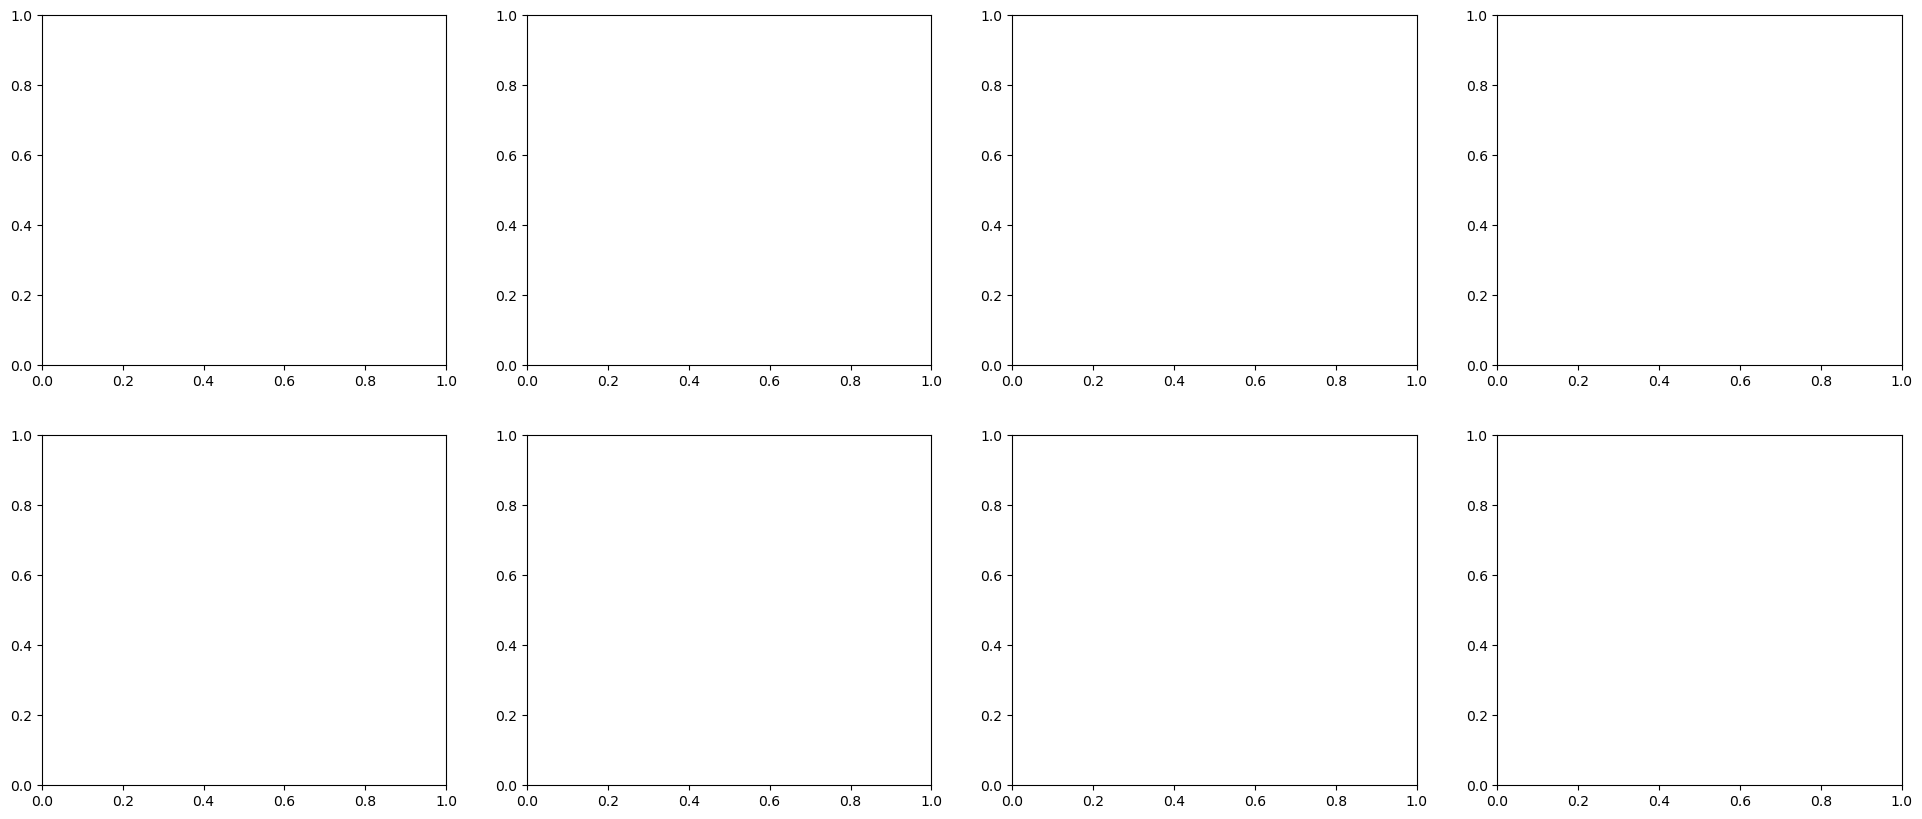

In [40]:
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize = (cols * 6, rows * 5))
axes[4]

In [ ]:
sc_obs = os.listdir("loom_output/split_ad/sc/")
stochastic_dict = dict()
dynamical_dict = dict()
for ob in sc_obs:
    ob = ob.removesuffix(".ad")
    stochastic_dict[ob] = anndata.read(
        "loom_output/split_ad/stochastic/sc/" + ob + ".ad"
    )
    dynamical_dict[ob] = anndata.read(
        "loom_output/split_ad/sc/" + ob + ".ad"
    )
    # add confidence scores
    scv.tl.velocity_confidence(stochastic_dict[ob])
    scv.tl.velocity_confidence(dynamical_dict[ob])


In [ ]:
for ob in sc_obs:
    velo_len_conf_table(ob.removesuffix(".ad"))

# Compare Velocity Driving Genes

I'm going to find what genes are driving the velocity results in each model, and then compare for each dataset. My hope is that it is the same genes driving these results.

In [ ]:
stoc_genes = dict()
dyn_genes = dict()
for ob in sc_obs:
    ob = ob.removesuffix(".ad")
    # for stochastic
    stoc_ob = stochastic_dict[ob]
    scv.tl.rank_velocity_genes(stoc_ob, groupby = "Ann_Level3", n_genes = 100)
    stoc_genes[ob] = pd.DataFrame(stoc_ob.uns["rank_velocity_genes"]["names"])
    # for dynamical
    dyn_ob = dynamical_dict[ob]
    scv.tl.rank_velocity_genes(dyn_ob, groupby = "Ann_Level3", n_genes = 100)
    dyn_genes[ob] = pd.DataFrame(dyn_ob.uns["rank_velocity_genes"]["names"])

In [54]:
stoc_genes["mm_mets_cancer_cells_fdl"]

,Basal_Progenitor,Fibrogenic,Interactive,MP_Progenitor,Proliferative
0,Timp3,Naaladl2,Sash1,Cd74,Prc1
1,Galnt15,Sox5,Alcam,Nnmt,Cenpf
2,Clca3a1,Klf9,Abca1,AA465934,Top2a
3,Prelp,Podn,Lrp4,Mmp2,Gm50147
4,Ighg1,Prkg1,Shtn1,Mxra8,Mki67
...,...,...,...,...,...
95,Gfpt2,Prg4,H2-Eb1,Inhba,Gm26632
96,Olfr1033,Ndrg1,Lrrc1,Col4a5,Ctsk
97,Aqp1,Rbbp8,Ptn,Mme,Stmn2
98,Id2,Hpgd,Postn,C1qtnf7,Gm26802


# Trajectory Analysis

In [ ]:
stoc_keys = list(stochastic_dict.keys())
keys = "velocity_length", "velocity_confidence"
for ob in stoc_keys:
    tmp = stochastic_dict[ob]
    scv.tl.velocity_confidence(tmp)
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    stochastic_dict[ob] = tmp


dyn_keys = list(dynamical_dict.keys())
for ob in dyn_keys:
    tmp = dynamical_dict[ob]
    scv.tl.velocity_confidence(tmp)
    tmp.uns['neighbors']['distances'] = tmp.obsp['distances']
    tmp.uns['neighbors']['connectivities'] = tmp.obsp['connectivities']
    scv.tl.paga(tmp, groups='Ann_Level3')
    dynamical_dict[ob] = tmp